In [2]:
import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split

In [11]:
seed = 0
data = pd.read_csv('fastai-project/homework/data/NELA19/data_content.csv')
categories = data.label.unique()

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=seed)
x_train = train.text.values
y_train = train.label.values
x_test = test.text.values
y_test = test.label.values

## STEP 1: Preprocess Data and Build a Transformer Model

In [18]:
avg_len = int(sum([len(x) for x in x_train])/len(x_train))

In [19]:
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=categories)
train = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=6)

preprocessing train...
language: en
train sequence lengths:
	mean : 491
	95percentile : 1274
	99percentile : 2429


/opt/conda/lib/python3.7/site-packages/ktrain/text/preprocessor.py:509: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


preprocessing test...
language: en
test sequence lengths:
	mean : 500
	95percentile : 1300
	99percentile : 2482


## STEP 2 [Optional]: Estimate a Good Learning Rate

simulating training for different learning rates... this may take a few moments...
Train for 3333 steps
Epoch 1/2
3333/3333 [==============================] - 728s 219ms/step - loss: 1.4107 - accuracy: 0.3651
Epoch 2/2
3333/3333 [==============================] - 719s 216ms/step - loss: 1.8800 - accuracy: 0.1941


done.
Visually inspect loss plot and select learning rate associated with falling loss


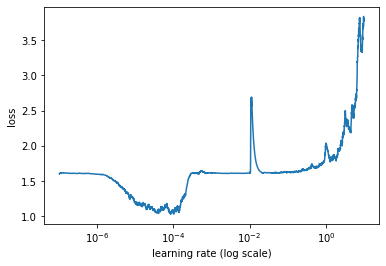

In [20]:
learner.lr_find(show_plot=True, max_epochs=2)

## STEP 3: Train Model

In [21]:
learner.fit_onecycle(5e-5, 1)



begin training using onecycle policy with max lr of 5e-05...
Train for 3334 steps, validate for 157 steps
3334/3334 [==============================] - 773s 232ms/step - loss: 0.9545 - accuracy: 0.6161 - val_loss: 0.6672 - val_accuracy: 0.7534


In [23]:
learner.save_model('fastai-project/homework/models/1epoch_BERT')

In [24]:
learner.unfreeze()

simulating training for different learning rates... this may take a few moments...
Train for 3333 steps
2928/3333 [=========================>....] - ETA: 1:28 - loss: 1.1444 - accuracy: 0.4876

done.
Visually inspect loss plot and select learning rate associated with falling loss


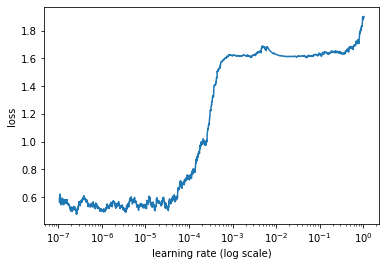

In [25]:
learner.lr_find(show_plot=True, max_epochs=1)

In [26]:
learner.fit_onecycle(5e-5, 1)



begin training using onecycle policy with max lr of 5e-05...
Train for 3334 steps, validate for 157 steps
3334/3334 [==============================] - 773s 232ms/step - loss: 0.5684 - accuracy: 0.7908 - val_loss: 0.5790 - val_accuracy: 0.7894


In [27]:
learner.save_model('fastai-project/homework/models/2epoch_BERT')

In [42]:
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Train for 3334 steps, validate for 157 steps
Epoch 1/4
3334/3334 [==============================] - 771s 231ms/step - loss: 0.3347 - accuracy: 0.8832 - val_loss: 0.6067 - val_accuracy: 0.7778
Epoch 2/4
3334/3334 [==============================] - 769s 231ms/step - loss: 0.3277 - accuracy: 0.8858 - val_loss: 0.7591 - val_accuracy: 0.7238
Epoch 3/4
3334/3334 [==============================] - 768s 230ms/step - loss: 0.2459 - accuracy: 0.9139 - val_loss: 0.7221 - val_accuracy: 0.7824
Epoch 4/4
3334/3334 [==============================] - 768s 230ms/step - loss: 0.0734 - accuracy: 0.9771 - val_loss: 0.8488 - val_accuracy: 0.7996


In [43]:
learner.save_model('fastai-project/homework/models/6epoch_BERT')

## STEP 4: Evaluate/Inspect Model

In [28]:
learner.validate(class_names=t.get_classes())

                     precision    recall  f1-score   support

          left_bias       0.73      0.73      0.73       947
   left_center_bias       0.74      0.76      0.75       962
questionable_source       0.79      0.77      0.78      1022
         right_bias       0.86      0.86      0.86      1040
  right_center_bias       0.81      0.82      0.82      1029

           accuracy                           0.79      5000
          macro avg       0.79      0.79      0.79      5000
       weighted avg       0.79      0.79      0.79      5000



array([[689, 111,  65,  36,  46],
       [105, 734,  25,  24,  74],
       [ 75,  32, 791,  66,  58],
       [ 46,  21,  66, 893,  14],
       [ 31,  94,  49,  15, 840]])

In [29]:
# the one we got most wrong
learner.view_top_losses(n=1, preproc=t)

----------
id:4536 | loss:6.4 | true:left_center_bias | pred:right_bias)



In [31]:
#print(x_test[4536])

## STEP 5: Make Predictions on New Data in Deployment

In [32]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [41]:
predictor.predict("""
Seconds after Veronica opened her eyes in the hospital, she knew who had put her there. Her body ached; her head throbbed.
The night before, the 25-year-old mother-of-five was busy buying medication for her children in Moroto, a town in northeast Uganda. When Veronica (whose surname we're not using to protect her identity) returned home, her husband picked up a sharp object and stabbed her in the right eye. He then beat her, and when she blacked out, he fled, she said.
Two legal volunteers from the Association of Women Lawyers (FIDA-U), an organization that provides legal aid and access to essential services for women, were already working on the ground in the community. They heard Veronica's screams and decided to investigate. After finding her lying unconscious on the floor, they called their colleague Jacob Lokuda, a front-line legal clerk who responds rapidly to violent incidents, and who recounted what happened.
"She had lost a lot of blood," said 25-year-old Lokuda, "it was very nasty."
The three men carried her to Moroto hospital, roughly four miles away. By car, the journey is a 20-minute drive; by foot, it took over one hour. Veronica drifted in and out of consciousness, mumbling that she thought she was already dead. 


On May 4, Ugandan President Yoweri Museveni began to loosen the country's strict anti-coronavirus restrictions after more than six weeks in lockdown. While businesses including hardware shops and wholesale stores have now reopened, the existing ban on all public and private transport remains intact.
This means, critics say, that many women will continue not only to be trapped at home with a potential perpetrator, but they remain unable to travel to seek medical treatment, refuge or help.
The country currently has 160 confirmed Covid-19 cases and no fatalities, according to Johns Hopkins University.
Many women, like Veronica, have found themselves forced to spend more time with partners who were already abusive. Economic worry is an added tension. More than 80% of Ugandans work in the informal sector and many have lost their jobs due to the Covid-19 restrictions.
"We stopped a lot to catch our breath," says Lokuda, who had already jogged 40 minutes to Veronica's village from his own home. "We didn't have any protective gear, such as gloves, but she needed medical attention," he adds.
"He had gone beyond reason," Veronica said over the phone.
In late March, Museveni indicated that domestic violence is not life threatening and should not be considered so during the Covid-19 pandemic.
"We're just dealing with a few things [that are] life-threatening. Childbirth, snakebite, heart attack -- finish. What else is there? We're not dealing with all problems. Somebody is drunk and has beaten his wife? No, no, no," he said.
He has since addressed the issue and said he is devising a "comprehensive plan" on how best to handle the situation.
""")

'left_center_bias'

In [34]:
predictor.explain('Jesus Christ is the central figure of Christianity.')

In [35]:
predictor.save('fastai-project/homework/models/NELA_content_small_BERT_predictor')